## Library imports

In [2]:
#!pip install augmax
# Install the newest JAXlib version.
#!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
#!pip install --upgrade -q git+https://github.com/google/flax.git

## Permutation utils

In [3]:
from collections import defaultdict
from typing import NamedTuple

import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm

def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)
  print(perm)



## Utils

In [4]:
import operator
import re
import time
import matplotlib.pyplot as plt

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


## MLP model and dataset

In [5]:

"""Train an MLP on MNIST on one random seed. Serialize the model for
interpolation downstream."""
import argparse

import augmax
import flax
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn
from flax.training.train_state import TrainState
from jax import jit, random, tree_map, value_and_grad, vmap
from tqdm import tqdm

# See https://github.com/tensorflow/tensorflow/issues/53831.

# See https://github.com/google/jax/issues/9454.
tf.config.set_visible_devices([], "GPU")

activation = nn.relu

class MLPModel(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(10)(x)
    x = nn.log_softmax(x)
    return x

def make_stuff(model):
  normalize_transform = augmax.ByteToFloat()

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, {"num_correct": num_correct}

  # Stan's addition for saving predictions of the model to see how they differ
  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(train_state, images_f32, labels):
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
    )

  # Stan's addition for saving predictions of the model to see how they differ
  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits, y_onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        y_onehots,
    )

  return {
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }

def load_datasets():
  """Return the training and test datasets, unbatched."""
  # See https://www.tensorflow.org/datasets/overview#as_batched_tftensor_batch_size-1.
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds



## Runs details

In [6]:
num_epochs = 100
batch_size = 500
seed = 12421
config_optimizer = "sgd" # sgd does not work
learning_rate = 1e-3

runs_to_collect = 2

rng = random.PRNGKey(seed)

In [7]:
# storing model params after training
flattened_models_list = []

for run_i in range(runs_to_collect):

  rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
  rngmix = lambda rng, x: random.fold_in(rng, hash(x))

  model = MLPModel()
  stuff = make_stuff(model)

  print("--------------------------")
  print(f"Starting run {run_i}")


  train_ds, test_ds = load_datasets()
  print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
  print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

  num_train_examples = train_ds["images_u8"].shape[0]
  num_test_examples = test_ds["images_u8"].shape[0]
  assert num_train_examples % batch_size == 0
  print("num_train_examples", num_train_examples)
  print("num_test_examples", num_test_examples)

  if config_optimizer == "sgd":
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=1e-6,
        peak_value=learning_rate,
        warmup_steps=10,
        # Confusingly, `decay_steps` is actually the total number of steps,
        # including the warmup.
        decay_steps=num_epochs * (num_train_examples // batch_size),
    )
    tx = optax.sgd(lr_schedule, momentum=0.9)
  elif config_optimizer == "adam":
    tx = optax.adam(learning_rate)

  train_state = TrainState.create(
      apply_fn=model.apply,
      params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
      tx=tx,
  )

  for epoch in tqdm(range(num_epochs)):
    infos = []
  
    batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
        (-1, batch_size))
    for i in range(batch_ix.shape[0]):
      p = batch_ix[i, :]
      images_u8 = train_ds["images_u8"][p, :, :, :]
      labels = train_ds["labels"][p]
      train_state, info = stuff["step"](train_state, images_u8, labels)
    

    train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
    train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

    
    actest_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                    10_000)

    params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                          flatten_params({"params_l2": train_state.params}))
    
    
  # summary
  print("-----------------")
  print(f"RUN {run_i} FINISHED!")
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                10_000)
  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                60_000)
  print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

  flattened_models_list.append(flatten_params(train_state.params))


--------------------------
Starting run 0


2022-12-14 09:29:41.121858: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


train_ds labels hash -2083114932408509281
test_ds labels hash 933651475060242277
num_train_examples 60000
num_test_examples 10000


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


-----------------
RUN 0 FINISHED!
Run=0 test loss=0.16564010083675385 test accuracy=0.9514999985694885 train loss=0.16039948165416718 train accuracy=0.954633355140686
--------------------------
Starting run 1
train_ds labels hash -2083114932408509281
test_ds labels hash 933651475060242277
num_train_examples 60000
num_test_examples 10000


100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


-----------------
RUN 1 FINISHED!
Run=1 test loss=0.16809609532356262 test accuracy=0.9498000144958496 train loss=0.16236530244350433 train accuracy=0.9538333415985107


In [8]:
# flattening params
assert len(flattened_models_list) >= 2
flattened_model1 = flattened_models_list[0]
flattened_model2 = flattened_models_list[1]

## Permuting the model

In [9]:
permutation_spec = mlp_permutation_spec(3)
final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                    flattened_model1, flattened_model2)

0/P_0: 86.61100006103516
0/P_1: 45.83926773071289
0/P_2: 27.56157684326172
1/P_0: 10.167549133300781
1/P_2: 0.0
1/P_1: 1.0706558227539062
2/P_2: 2.4769134521484375
2/P_0: 1.8096237182617188
2/P_1: 0.17486572265625
3/P_0: 0.5741500854492188
3/P_1: 0.0022430419921875
3/P_2: 0.9475860595703125
4/P_0: 0.23919677734375
4/P_1: 0.0788726806640625
4/P_2: 0.8958206176757812
5/P_1: 0.054779052734375
5/P_2: 0.3226165771484375
5/P_0: 0.5840225219726562
6/P_1: 0.0522308349609375
6/P_2: 0.15251922607421875
6/P_0: 0.1121978759765625
7/P_2: 0.0
7/P_1: 0.094635009765625
7/P_0: 0.2553863525390625
8/P_1: 0.0096435546875
8/P_0: 0.09647369384765625
8/P_2: 0.4929351806640625
9/P_0: 0.0
9/P_1: 0.0160980224609375
9/P_2: 0.17646026611328125
10/P_2: 0.0
10/P_0: 0.09656524658203125
10/P_1: 0.101898193359375
11/P_0: 0.1204376220703125
11/P_2: 0.5377883911132812
11/P_1: 0.0735321044921875
12/P_0: 0.238128662109375
12/P_1: 0.036041259765625
12/P_2: 0.43264007568359375
13/P_2: 0.0
13/P_1: 0.061859130859375
13/P_0: 0

In [10]:
# applying the permutation to the second model
flattened_model1_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model1)
        )
flattened_model2_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model2)
        )

## Performance verification

### Model 1

In [11]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                  60_000)
print("Model 1")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1
train_loss=0.16039948165416718 train_accuracy=0.954633355140686
test_loss=0.16564010083675385 test_accuracy=0.9514999985694885


### Model 2

In [12]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                  60_000)
print("Model 2")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2
train_loss=0.16236530244350433 train_accuracy=0.9538333415985107
test_loss=0.16809609532356262 test_accuracy=0.9498000144958496


### Model 1 with permutation

In [13]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), train_ds,
                                                                  60_000)
print("Model 1 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1 with permutation
train_loss=0.16039951145648956 train_accuracy=0.954633355140686
test_loss=0.16564010083675385 test_accuracy=0.9514999985694885


### Model 2 with permutation

In [14]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                  60_000)
print("Model 2 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2 with permutation
train_loss=0.16236528754234314 train_accuracy=0.9538333415985107
test_loss=0.16809609532356262 test_accuracy=0.9498000144958496


## Weight vector analysis

In [15]:
flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)

In [16]:
# all in long vectors
keys = flattened_model1.keys()

v1 = jnp.concatenate([flattened_model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([flattened_model2[key].reshape([-1]) for key in keys],axis=0)
v1_perm = jnp.concatenate([flattened_model1_permuted_flat[key].reshape([-1]) for key in keys],axis=0)
v2_perm = jnp.concatenate([flattened_model2_permuted_flat[key].reshape([-1]) for key in keys],axis=0)

In [17]:
vectors_to_show = [
    ("model 1", v1),
    ("model 2", v2),
    ("model 1 + perms", v1_perm),
    ("model 2 + perms", v2_perm), 
]

for vector_str, vector in vectors_to_show:
  print(f"{vector_str} length**2={(jnp.sum(vector**2))}")

# the permutation should preserve the length

model 1 length**2=1602.0555419921875
model 2 length**2=1600.791748046875
model 1 + perms length**2=1602.0557861328125
model 2 + perms length**2=1600.7918701171875


In [18]:
coses_grid = np.zeros((len(vectors_to_show),len(vectors_to_show)))
for i,(vector_str1, vector1) in enumerate(vectors_to_show):
  for j,(vector_str2, vector2) in enumerate(vectors_to_show):
    cos_now = jnp.sum(vector1*vector2)/jnp.sqrt(jnp.sum(vector1**2))/jnp.sqrt(jnp.sum(vector2**2))
    print(f"cos({vector_str1},{vector_str2})={cos_now}")
    coses_grid[i,j] = cos_now

cos(model 1,model 1)=1.0000001192092896
cos(model 1,model 2)=-0.00025914644356817007
cos(model 1,model 1 + perms)=0.003698732703924179
cos(model 1,model 2 + perms)=0.11450167745351791
cos(model 2,model 1)=-0.00025914644356817007
cos(model 2,model 2)=1.0
cos(model 2,model 1 + perms)=0.0009715243941172957
cos(model 2,model 2 + perms)=0.0046501136384904385
cos(model 1 + perms,model 1)=0.0036987324710935354
cos(model 1 + perms,model 2)=0.0009715243359096348
cos(model 1 + perms,model 1 + perms)=1.0
cos(model 1 + perms,model 2 + perms)=-0.0002591460943222046
cos(model 2 + perms,model 1)=0.11450167000293732
cos(model 2 + perms,model 2)=0.0046501136384904385
cos(model 2 + perms,model 1 + perms)=-0.00025914612342603505
cos(model 2 + perms,model 2 + perms)=1.0000001192092896


## Linear interpolations of weights = test for linear mode connectivity

In [19]:
def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )

### Model 1 -> Model 2

0 0.0 0.1656401
1 0.07142857142857142 0.19852611
2 0.14285714285714285 0.299755
3 0.21428571428571427 0.5209338
4 0.2857142857142857 0.8814376
5 0.3571428571428571 1.2953143
6 0.42857142857142855 1.6152084
7 0.5 1.7277489
8 0.5714285714285714 1.6017652
9 0.6428571428571428 1.2807621
10 0.7142857142857142 0.8735411
11 0.7857142857142857 0.5197818
12 0.8571428571428571 0.30115357
13 0.9285714285714285 0.20060246
14 1.0 0.1680961


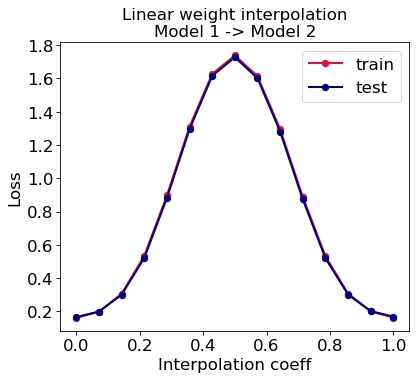

In [20]:
ts = np.linspace(0.0,1.0,15)

start_vector = flattened_model1
stop_vector = flattened_model2
name = "Model 1 -> Model 2"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

plt.figure(figsize=(6,5),dpi=75)
plt.gca().patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 2 + permutations

0 0.0 0.1656401
1 0.07142857142857142 0.18843591
2 0.14285714285714285 0.24920441
3 0.21428571428571427 0.3738807
4 0.2857142857142857 0.58438325
5 0.3571428571428571 0.8620301
6 0.42857142857142855 1.1242603
7 0.5 1.2605635
8 0.5714285714285714 1.208948
9 0.6428571428571428 0.9870623
10 0.7142857142857142 0.68843395
11 0.7857142857142857 0.42982814
12 0.8571428571428571 0.2697399
13 0.9285714285714285 0.19373822
14 1.0 0.1680961


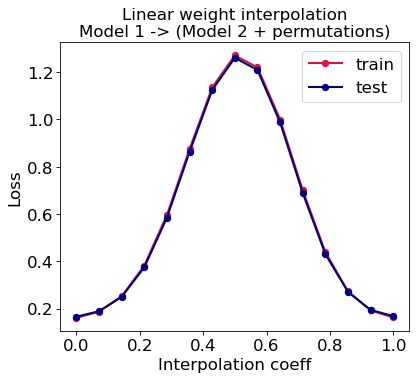

In [21]:
ts = np.linspace(0.0,1.0,15)

start_vector = flattened_model1
stop_vector = flattened_model2_permuted_flat
name = "Model 1 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Predictions

In [22]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)
  
  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))
  


In [23]:
models_to_show = [
    ("model 1", flattened_model1),
    ("model 2", flattened_model2),
    ("model 1 + perms", flattened_model1_permuted_flat),
    ("model 2 + perms", flattened_model2_permuted_flat), 
]

disagreement_grid = np.zeros((len(models_to_show),len(models_to_show)))
for i,(vector_str1, vector1) in enumerate(models_to_show):
  for j,(vector_str2, vector2) in enumerate(models_to_show):
    disagreement_now = compare_predictions(
        unflatten_params(vector1),
        unflatten_params(vector2)
        )
    print(f"Disagreemnt {vector_str1} vs {vector_str2}={disagreement_now}")
    disagreement_grid[i,j] = disagreement_now

Disagreemnt model 1 vs model 1=0
Disagreemnt model 1 vs model 2=165
Disagreemnt model 1 vs model 1 + perms=0
Disagreemnt model 1 vs model 2 + perms=165
Disagreemnt model 2 vs model 1=165
Disagreemnt model 2 vs model 2=0
Disagreemnt model 2 vs model 1 + perms=165
Disagreemnt model 2 vs model 2 + perms=0
Disagreemnt model 1 + perms vs model 1=0
Disagreemnt model 1 + perms vs model 2=165
Disagreemnt model 1 + perms vs model 1 + perms=0
Disagreemnt model 1 + perms vs model 2 + perms=165
Disagreemnt model 2 + perms vs model 1=165
Disagreemnt model 2 + perms vs model 2=0
Disagreemnt model 2 + perms vs model 1 + perms=165
Disagreemnt model 2 + perms vs model 2 + perms=0


## Loss landscape cuts

In [24]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



In [25]:
# testing it, should get all 0.0
rec = reconstruct(v1, flattened_model1, flattened_model1.keys())
for key in rec.keys():
  print(jnp.max(jnp.abs(flattened_model1[key] - rec[key])))
  assert jnp.max(jnp.abs(flattened_model1[key] - rec[key])) == 0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


### Cut model1 - model2 - (model2+perm)

In [26]:
model1 = flattened_model1
model2 = flattened_model2
model3 = flattened_model2_permuted_flat
cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model1.keys()

v1 = jnp.concatenate([model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([model2[key].reshape([-1]) for key in keys],axis=0)
v3 = jnp.concatenate([model3[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / jnp.sqrt(jnp.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - jnp.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / jnp.sqrt(jnp.sum(basis2**2.0))

scale = jnp.sqrt(jnp.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

acc_grid = np.zeros((len(t1s),len(t2s)))
loss_grid = np.zeros((len(t1s),len(t2s)))
logits_grid = np.zeros((len(t1s),len(t2s), 10000, 10))

for i1,t1 in enumerate(t1s):
  print(f"{i1}/{len(t1s)}")
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model1, keys)
    actest_loss, test_accuracy, logits, onehots = stuff["dataset_predictions"](unflatten_params(reconstructed_flat), test_ds,
                                                                  10_000)
    logits_grid[i1,i2] = np.array(logits[0])
    
    acc_grid[i1,i2] = test_accuracy
    loss_grid[i1,i2] = actest_loss
  
def projection(vector):
  x = jnp.sum((vector - v1)*basis1_normed)/scale
  y = jnp.sum((vector - v1)*basis2_normed)/scale
  return x,y



0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21


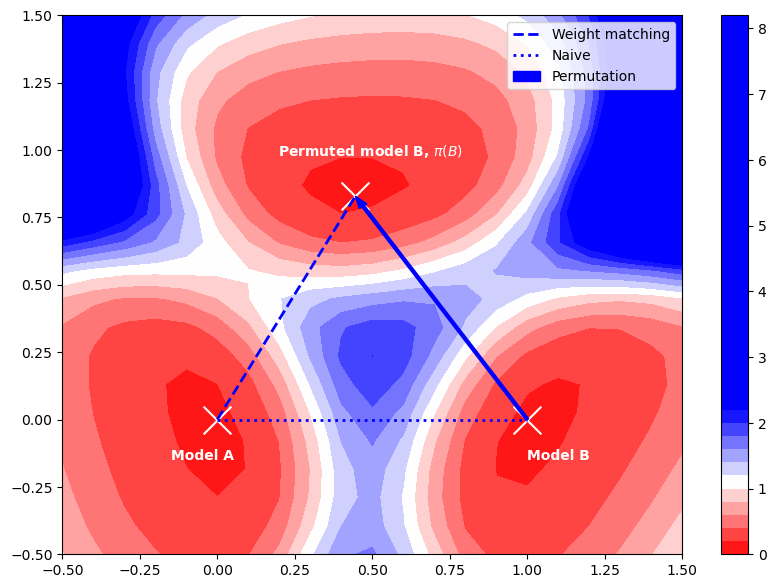

In [90]:
fig = plt.figure(figsize = (10,7),dpi=100)
fig.patch.set_facecolor('white')

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.bwr_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="x",color="white",s=400)


x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="x",color="white",s=400)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="x",color="white",s=400)  #π(B)


plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="blue",label="Weight matching")
plt.plot([x1,x2],[y1,y2],linewidth=2,linestyle="dotted",color="blue",label="Naive")
plt.arrow(x2,y2,x2p - x2,y2p - y2, length_includes_head=True, width=.01, label="Permutation", color="blue")

plt.text(x1 - .15, y1 - .15, "Model A", color="white", fontsize=10, weight="bold")
plt.text(x2, y2 - .15, "Model B", color="white", fontsize=10, weight="bold")
plt.text(x2p - .25, y2p + .15, "Permuted model B, $\pi(B)$", color="white", fontsize=10, weight="bold")


plt.legend(fontsize=10)

plt.show()
